# National Tsing Hua University Robust and Stochastic Portfolio Optimization (Fall 2021)

 - Programming HW 7

In [2]:
# Basic
import cvxpy as cp
import numpy as np
import pandas as pd 
import yfinance as yf 

# Self-Built Function
from Utils.Convex_Hull            import portfolio_convex_hull
from Utils.Portfolio_Summary      import Backtest_Summay_DF

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

# Pick 15 Assets

[*********************100%***********************]  15 of 15 completed
          Equities Covex Hull
----------------------------------------
      Unbiased_Std  Expected_Returns
FB        0.295094          0.255410
MSFT      0.210075          0.445800
AAPL      0.250682          0.320072
AMZN      0.240619          0.043524
NFLX      0.321124          0.188112
GOOG      0.236695          0.535123
TSLA      0.546656          0.564916
AMD       0.424530          0.532061
JPM       0.213597          0.280220
KO        0.152102          0.126162
QCOM      0.342059          0.273793
SBUX      0.225184          0.140127
SQ        0.506211         -0.185070
TM        0.215860          0.207014
COST      0.189026          0.440119
----------------------------------------


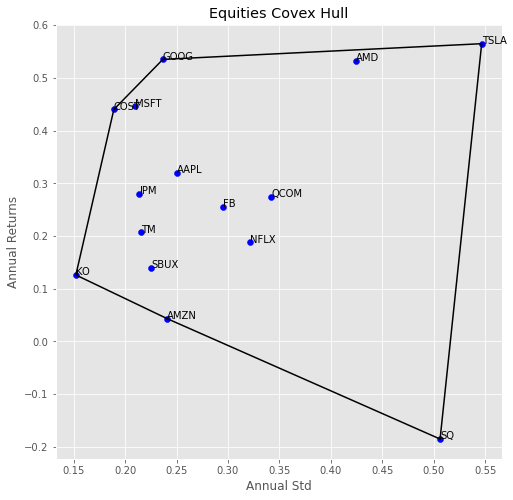

In [4]:
start_date = '2020-12-31'
end_date   = '2022-01-01'

# yfinance likes the tickers formatted as a list
tickers   = ["FB","MSFT","AAPL","AMZN","NFLX",'GOOG','TSLA','AMD','JPM','KO','QCOM','SBUX','SQ','TM','COST']
ticks     = yf.Tickers(tickers)
Stock_DF  = ticks.history(start=start_date, end=end_date).Close
Stock_DF  = Stock_DF.dropna(axis=0)
Stock_DF  = Stock_DF[tickers]
Return_DF = Stock_DF.pct_change()[1:]


Expected_Return   = Stock_DF.pct_change().mean() 
Unbiased_Std      = Stock_DF.pct_change().std() 

CovexHull_DF = pd.DataFrame({
    "Unbiased_Std" : Unbiased_Std ,
    "Expected_Returns" : Expected_Return ,
    })

portfolio_convex_hull(CovexHull_DF)

# Calculate Valu at Risk  and Conditional Value at Risk
    - Take Equal Weighted Portfolio to Compute and Compare VaR , CVaR

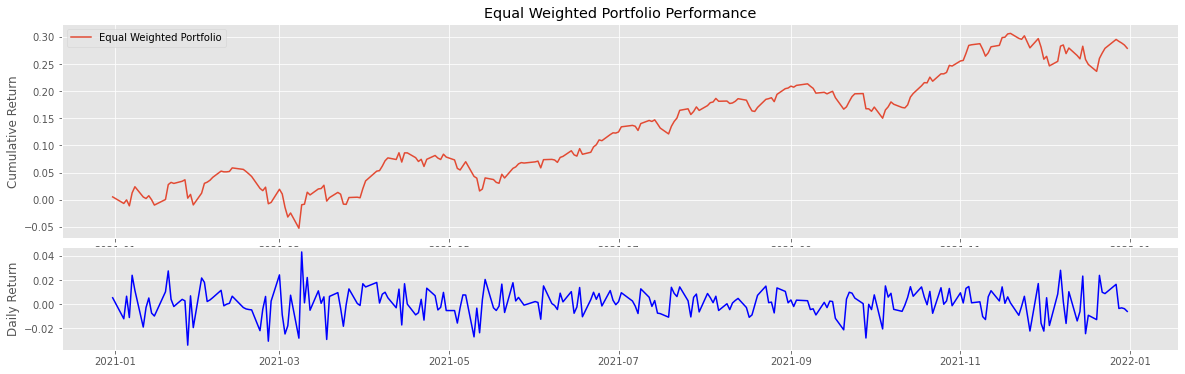

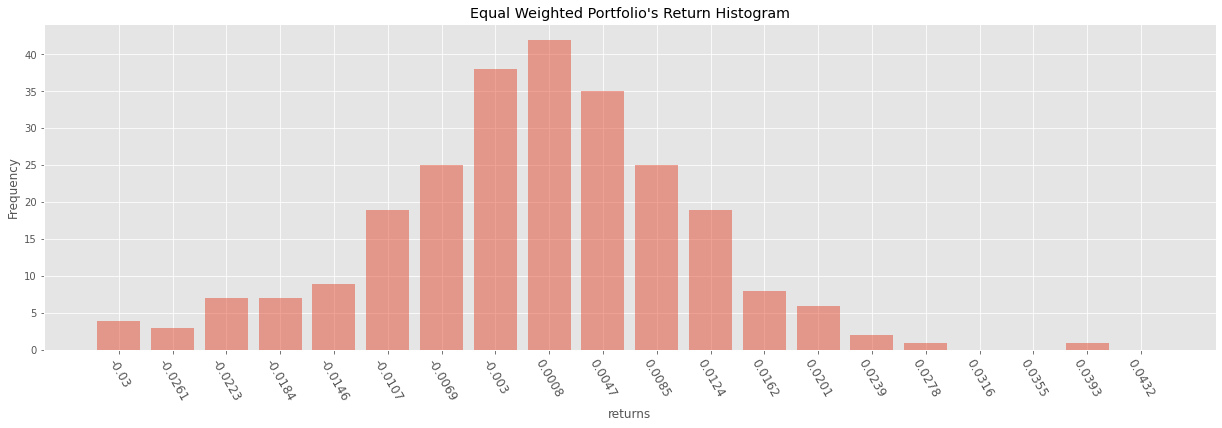

,Start Date,End Date,Periods,-,Annual Return,Annual Volitiliy,Cumulative Return,Sharpe Ratio,Calmar Ratio,Daily Value at Risk,Conditional Value at Risk,Maximum Drawdown
Equal Weighted Portfolio,2020-12-31,2021-12-31,254,-,0.277826,0.180051,0.278928,1.543037,2.500454,-0.020751,-0.025904,0.11111


In [5]:
def plot_PDF(Daily_Returns,step,ticker):
    
    """
    Plot Daily Returns' Histogram
    """

    def find_frequency(returns,res_min,res_max):
        pos = np.where( (returns>= res_min) & (returns < res_max) )
        return returns[pos]

    returns  = np.sort(Daily_Returns)
    returns_min = np.min(returns)
    returns_max = np.max(returns)
    n           = (returns_max - returns_min) / step
    index     = []
    frequency = []

    for _ in range(step):

        returns_min+=n
        index.append(np.round(returns_min,decimals=4))
        frequency.append( len(find_frequency(returns,returns_min,returns_min+n) ))

    frequency_df = pd.DataFrame()
    frequency_df['index'] = index
    frequency_df["frequency"] = frequency
    frequency_df = frequency_df.sort_values(by='index').reset_index(drop=True)

    fig , ax = plt.subplots(figsize=(21,6))
    ax.set_title(str(ticker)+"'s Return Histogram")
    ax.bar( x=frequency_df.index ,  height=frequency_df['frequency'].values, align='center', alpha=0.5 , width=0.8)
    plt.xticks(frequency_df.index ,  frequency_df["index"].to_list(),rotation=-60,fontsize=12)
    ax.set_ylabel('Frequency')
    ax.set_xlabel('returns')
    plt.show()


Equal_Weighted_Portfolio = Return_DF.mean(axis=1)

# Cumulative Return & Daily return
plt.subplots(figsize=(20,6))
ax1 = plt.subplot2grid((6,1),(0,0),rowspan=4,colspan=1)
ax1.set_title('Equal Weighted Portfolio Performance')
ax1.plot(Equal_Weighted_Portfolio.index,Equal_Weighted_Portfolio.values.cumsum(),label='Equal Weighted Portfolio')
ax1.set_ylabel('Cumulative Return')
ax1.legend()

ax2 = plt.subplot2grid((6,1),(4,0),rowspan=3,colspan=1)
ax2.plot(Equal_Weighted_Portfolio.index,Equal_Weighted_Portfolio.values,color='blue')
ax2.set_ylabel('Daily Return')
plt.show()


plot_PDF(Daily_Returns=Equal_Weighted_Portfolio.values,step = 20 ,ticker = 'Equal Weighted Portfolio')
Backtest_Summay_DF(Name="Equal Weighted Portfolio",Returns=Equal_Weighted_Portfolio).T

# CVaR Portfolio Optimization Model 

In [6]:
class Portfolio_Conditional_VaR():

    """
    Asset_return --> matrix with (n,m)
    Weight       --> vector with (n,1)
    y            --> scalar value
    """
    
    def __init__(self,asset_returns,alpha=0.05):

        self.u              = np.mean(asset_returns).values
        self.alpha          = alpha
        self.asset_returns  = asset_returns.values


        self.weight         = cp.Variable((asset_returns.shape[1],1))
        self.y              = cp.Variable()

    # Constraint
    def constraint_1(self,weight) : 

        return  [ cp.sum(weight) == 1 ] 

    def constraint_2(self,weight) : 

        return  [ weight[i] >= 0 for i in range(weight.shape[0])] 
    
    def constraint_3(self,weight,y):

        return [ self.asset_returns[i] @ weight - y >= 0 for i in range(self.asset_returns.shape[0]) ] 

    def constraint_4(self,weight,y):

        return [ self.asset_returns[i] @ weight - y >=  (-self.asset_returns[i] @ weight + y)  for i in range(self.asset_returns.shape[0]) ] 

    # Optimizex
    def Optimize(self):

        constraints = []
        constraints += self.constraint_1(self.weight) 
        constraints += self.constraint_2(self.weight) 
        constraints += self.constraint_3(self.weight,self.y) 
        constraints += self.constraint_4(self.weight,self.y) 

        var_list           = [ self.asset_returns[i] @ self.weight - self.y for i in range(self.asset_returns.shape[0]) ]
        average_var        = cp.sum(var_list) / self.asset_returns.shape[0]

        Objective_Function   =  self.y + average_var / (1-self.alpha)

        prob  = cp.Problem( cp.Minimize(Objective_Function) , constraints )
        
        return prob , self.weight , self.y

Min F(x)     :  0.0016001298121452595
Total Weight :  0.9999999999999999
Var          :  -0.024116194313152196


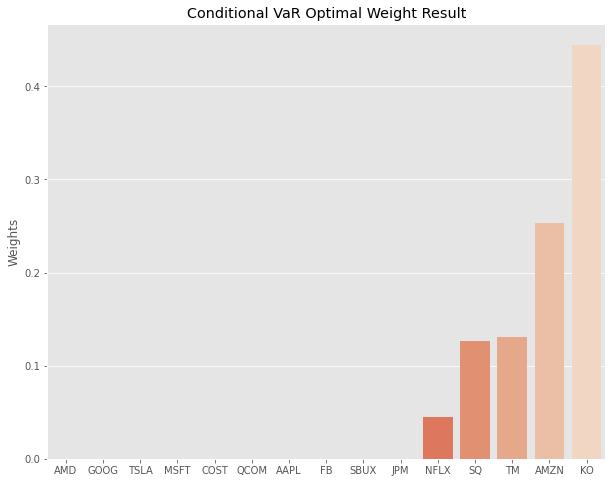

,AMD,GOOG,TSLA,MSFT,COST,QCOM,AAPL,FB,SBUX,JPM,NFLX,SQ,TM,AMZN,KO
Weights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0449,0.1266,0.1307,0.2529,0.4448


In [7]:
Conditional_Var_Model  = Portfolio_Conditional_VaR(asset_returns=Return_DF,alpha=0.05)
prob , weight ,y       = Conditional_Var_Model.Optimize()

print("Min F(x)     : "  , prob.solve()            )
print("Total Weight : "  , np.sum(weight.value)    )
print("Var          : "  , y.value                 )

# Figure
Weight_result = pd.DataFrame(weight.value , columns=['Weights'],index=tickers ).sort_values(by='Weights')
fig = plt.figure(figsize=(10,8))
ax  = sns.barplot(x=Weight_result.index,y=Weight_result.Weights,palette="rocket").set(title='Conditional VaR Optimal Weight Result')
plt.show()

Weight_result.round(decimals=4).T

# In Sample Periods Result 

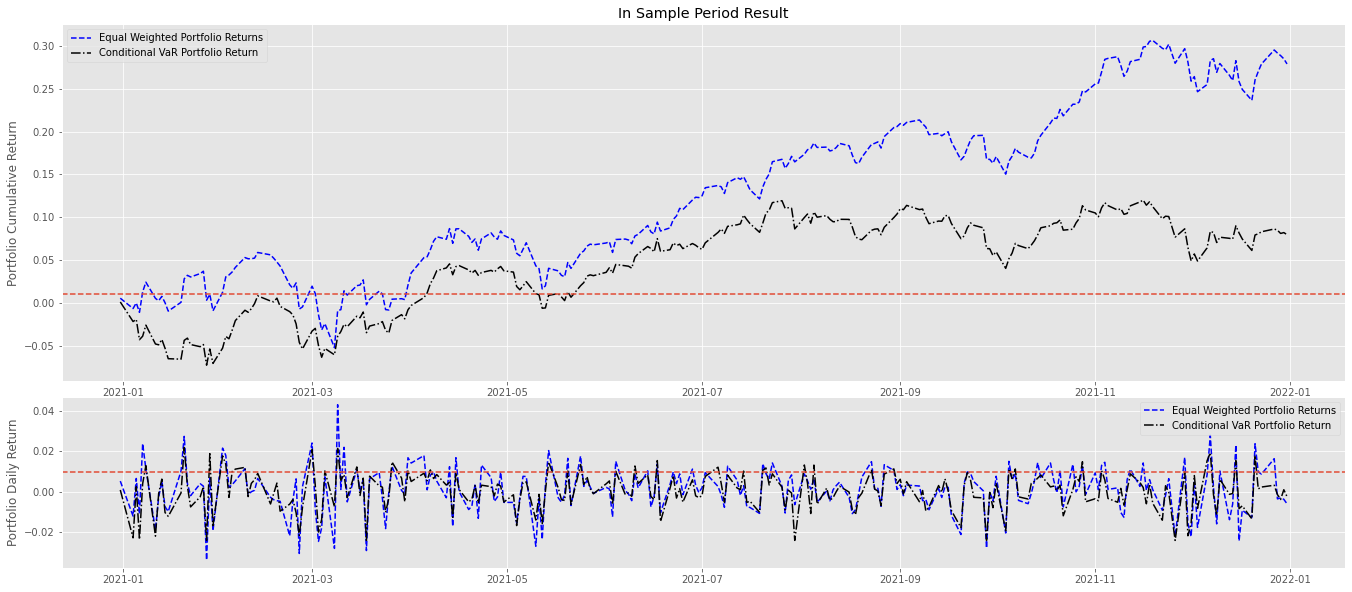

,Equal Weighted Portfolio,Conditional VaR Portfolio
Start Date,2020-12-31,2020-12-31
End Date,2021-12-31,2021-12-31
Periods,254,254
-,-,-
Annual Return,0.277826,0.079207
Annual Volitiliy,0.180051,0.146819
Cumulative Return,0.278928,0.079521
Sharpe Ratio,1.543037,0.539487
Calmar Ratio,2.500454,1.002313
Daily Value at Risk,-0.020751,-0.017213


In [8]:
Equak_Weighted_Portfolio   = pd.DataFrame(Return_DF.values @ np.array([ 1/ Return_DF.shape[1] for i in range(Return_DF.shape[1])]), columns=['Equal Weighted Portfolio Returns'] , index=Return_DF.index)
Conditional_VaR_Portfolio  = pd.DataFrame(Return_DF.values @ weight.value, columns=['Conditional VaR Portfolio Return'] , index=Return_DF.index )


plt.subplots(figsize=(23,10))
ax1 = plt.subplot2grid((6,1),(0,0),rowspan=4,colspan=1)
ax1.set_title("In Sample Period Result")
ax1.plot(Equak_Weighted_Portfolio.index    , Equak_Weighted_Portfolio['Equal Weighted Portfolio Returns'].cumsum()    ,color='blue'  ,label='Equal Weighted Portfolio Returns'  , linestyle='--' )
ax1.plot(Conditional_VaR_Portfolio .index  , Conditional_VaR_Portfolio ['Conditional VaR Portfolio Return'].cumsum()  ,color='black' ,label='Conditional VaR Portfolio Return'  , linestyle='-.' )


ax1.set_ylabel('Portfolio Cumulative Return')
ax1.axhline(0.01 , linestyle='--')
ax1.legend()

ax2 = plt.subplot2grid((6,1),(4,0),rowspan=3,colspan=1)
ax2.plot(Equak_Weighted_Portfolio.index    , Equak_Weighted_Portfolio['Equal Weighted Portfolio Returns']    ,color='blue'  ,label='Equal Weighted Portfolio Returns' ,linestyle='--' )
ax2.plot(Conditional_VaR_Portfolio .index  , Conditional_VaR_Portfolio ['Conditional VaR Portfolio Return']  ,color='black' ,label='Conditional VaR Portfolio Return' ,linestyle='-.' )


ax2.set_ylabel('Portfolio Daily Return')
ax2.axhline(0.01 , linestyle='--')
ax2.legend()
plt.show()

Equal_Weighted_Result     = Backtest_Summay_DF(Name="Equal Weighted Portfolio"  , Returns=Equak_Weighted_Portfolio   )
Conditional_VaR_Result    = Backtest_Summay_DF(Name="Conditional VaR Portfolio" , Returns=Conditional_VaR_Portfolio  )

pd.concat([Equal_Weighted_Result,Conditional_VaR_Result],axis=1)